In [1]:
import pandas as pd
import numpy as np

In [2]:
!gdown --id 1BW9yZtqryEJuNQ80cJQ9YJQuKS6YKJFT

Downloading...
From: https://drive.google.com/uc?id=1BW9yZtqryEJuNQ80cJQ9YJQuKS6YKJFT
To: /content/2110446-data-science-and-data-engineering-2021.zip
161MB [00:02, 72.4MB/s]


In [3]:
!unzip 2110446-data-science-and-data-engineering-2021.zip

Archive:  2110446-data-science-and-data-engineering-2021.zip
  inflating: DS_kaggle_edited_v3/Bangkok/Test/3H_temperature_Bangkok.csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Test/3H_wind_Bangkok.csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Test/Bangkok (Thailand timezone).csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Train/3H_temperature_Bangkok.csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Train/3H_wind_Bangkok.csv  
  inflating: DS_kaggle_edited_v3/Bangkok/Train/Bangkok.txt  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Test/3H_temperature_Chanthaburi.csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Test/3H_wind_Chanthaburi.csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Test/Chanthaburi (Thailand timezone).csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Train/3H_temperature_Chanthaburi.csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Train/3H_wind_Chanthaburi.csv  
  inflating: DS_kaggle_edited_v3/Chanthaburi/Train/Chanthaburi.txt  
  inflating: DS_kaggle_edited_v3/

In [4]:
!pip3 install --upgrade keras==2.1.3
!pip3 install --upgrade tensorflow==1.13.2

     |████████████████████████████████| 327kB 10.7MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.3 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 92.7MB 123kB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 3.2MB 53.0MB/s 
     |████████████████████████████████| 368kB 57.5MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [5]:
import math
import itertools

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
from numpy.random import seed
from keras.callbacks import ModelCheckpoint
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [6]:
def load_raw_data(data_type):
    if data_type not in ['Train','Test']:
        raise Exception('Invalid data type')
    location = ['Chanthaburi','Chiang Mai','Kanchanaburi','Bangkok','Khon Kaen','Songkhla']
    args = {'sep': '\t', 'comment': '%','header': None} if data_type == 'Train' else {}
    dot_ext = '.txt' if data_type == 'Train' else '(Thailand timezone).csv'
    temp = []
    wind = []
    pm = []
    # Load data
    for i in (location):
        temp.append(pd.read_csv('DS_kaggle_edited_v3/' + i + '/' + data_type + '/3H_temperature_' + i + '.csv'))
        wind.append(pd.read_csv('DS_kaggle_edited_v3/' + i + '/' + data_type + '/3H_wind_' + i + '.csv'))
        if i in ['Chiang Mai','Khon Kaen'] and data_type == 'Train':
            file_name = i.replace(' ','_')
        elif i in ['Bangkok','Chanthaburi'] and data_type == 'Test':
            file_name = i + ' '
        else:
            file_name = i
        pm.append(pd.read_csv('DS_kaggle_edited_v3/' + i + '/' + data_type + '/' + file_name + dot_ext, **args))
    # Clean
    for i in range(6) :
        temp[i]['datetime'] = pd.to_datetime(temp[i]['datetime'])
        temp[i].set_index(temp[i]['datetime'],inplace=True)
        temp[i].drop(columns={'datetime','lat','long'},inplace=True)
        temp[i] = temp[i].resample('h').ffill()
        wind[i]['datetime'] = pd.to_datetime(wind[i]['datetime'])
        wind[i].set_index(wind[i]['datetime'],inplace=True)
        wind[i].drop(columns={'datetime','WindDir'},inplace=True)
        wind[i] = wind[i].resample('h').ffill()
        if data_type == 'Train':
            pm[i]['datetime'] = pd.to_datetime({'year': pm[i][0], 'month': pm[i][1], 'day':pm[i][2],'hour': pm[i][3]})
            pm[i].drop([0,1,2,3,5,6],axis=1,inplace=True)
            pm[i].columns = ['PM2.5(µg/m3)', 'datetime']
            pm[i].set_index('datetime',inplace=True)
        else:
            data = [{'Time' :'2019-03-17 13:00:00','PM2.5(µg/m3)': pm[i]['PM2.5(µg/m3)'].mean()}]
            data.append({'Time' :'2019-03-18 7:00:00','PM2.5(µg/m3)': pm[i]['PM2.5(µg/m3)'].mean()})
            data = pd.DataFrame(data)
            data['Time'] = pd.to_datetime(data['Time'])
            data.set_index(data['Time'],inplace=True)
            data = data.resample('h').bfill()
            data.drop('Time',axis=1,inplace=True)
            pm[i]['Time'] = pd.to_datetime(pm[i]['Time'])
            pm[i].set_index(pm[i]['Time'],inplace=True)
            pm[i].drop(columns={'Time'},inplace=True)
            pm[i] = pm[i].append(data)
            pm[i].sort_index(inplace=True)  
    return (temp,wind,pm)

In [7]:
def transform_data(pm, seq_len, forecast):   
    n_features = len(pm.columns)
    data = pm.to_numpy()
    seq = seq_len - 1
    # Transform data
    data_range = range(seq,len(data) - forecast)
    x_train = np.array([data[index - seq: index + 1] for index in data_range])
    y_train = np.array([data[index + 1:index + forecast + 1] for index in data_range])
    date_y = np.array([pm.index[index + 1:index + forecast + 1] for index in data_range])
    date_x = np.array([pm.index[index] for index in data_range])
    # filter 
    extract_hour = lambda d: d.hour
    data_filter = np.vectorize(extract_hour)(date_x)
    x_train = x_train[data_filter%6 == 0]
    y_train = y_train[data_filter%6 == 0]
    date_y = date_y[data_filter%6 == 0]
    date_x = date_x[data_filter%6 == 0]
    # Transform data
    y_train = y_train[:,:,0]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    return (x_train, y_train, date_x, date_y)

In [8]:
def load_data(data_type):
    temp, wind, pm = load_raw_data(data_type)
    data = []
    for i in range(6):
        x = pm[i].merge(temp[i],how='left',left_index=True,right_index=True)  
        x = x.merge(wind[i],how='left',left_index=True,right_index=True)
        x = x.bfill()
        x['month'] = x.index.strftime('%m')
        x['month'] = pd.to_numeric(x['month'])
        data.append(x)
    prev_hour = 24
    forecast = 72
    X = []
    y = [] 
    x_date = []
    y_date = []
    for i in range (6):
        a, b, c, d = transform_data(data[i], prev_hour, forecast) 
        X.append(a)
        y.append(b)
        x_date.append(c)
        y_date.append(d)
    X = np.concatenate(X,axis=0)
    y = np.concatenate(y,axis=0)
    x_date = np.concatenate(x_date,axis=0)
    y_date = np.concatenate(y_date,axis=0)
    return (X, y, x_date, y_date)

In [9]:
# Load test data
X_test, y_test, test_x_date, test_y_date = load_data('Test')

In [10]:
# Expected output
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1])
y_test.shape

(481320,)

In [11]:
!gdown --id 1BTgetbtPaRklyJ6rAvbQX0h1WCMHffNK

Downloading...
From: https://drive.google.com/uc?id=1BTgetbtPaRklyJ6rAvbQX0h1WCMHffNK
To: /content/weights.best.hdf5
2.96MB [00:00, 93.8MB/s]


In [12]:
def build_model(layers):
    p = 0.3
    model = Sequential() 

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(p))

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(128))
    model.add(Dense(128))    
    model.add(Dense(72))

    model.compile(loss='mse',optimizer= 'adam', metrics=['mse'])

    return model

model = build_model([6, 24, 1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model.load_weights('weights.best.hdf5')
model.compile(loss='mse',optimizer='adam', metrics=['mse'])

In [14]:
predict = model.predict(X_test)
predict = predict.reshape(predict.shape[0]*predict.shape[1])

In [15]:
print(math.sqrt(mean_squared_error(y_test, predict)))

10.615486580998061


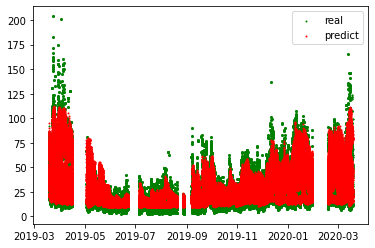

In [16]:
plt.scatter(test_y_date, y_test, c='g', label='real',s=1)
plt.scatter(test_y_date, predict, c='r', label='predict',s=1)
plt.legend()
plt.show()

In [17]:
miss_index = pd.read_csv('DS_kaggle_edited_v3/missing_index.csv')

In [18]:
prediction_index = pd.read_csv('DS_kaggle_edited_v3/output_index.csv')
prediction_index

,Unnamed: 0,predicted timestamp
0,0,Chanthaburi 2019-03-18 13:00:00
1,1,Chanthaburi 2019-03-18 14:00:00
2,2,Chanthaburi 2019-03-18 15:00:00
3,3,Chanthaburi 2019-03-18 16:00:00
4,4,Chanthaburi 2019-03-18 17:00:00
...,...,...
481315,81139,Songkhla 2020-03-18 14:00:00
481316,81140,Songkhla 2020-03-18 15:00:00
481317,81141,Songkhla 2020-03-18 16:00:00
481318,81142,Songkhla 2020-03-18 17:00:00


In [19]:
your_submission = pd.DataFrame(predict,columns=['Predicted'])

In [20]:
output = pd.DataFrame(y_test,columns=['Predicted'])

In [21]:
your_submission['datetime index'] = prediction_index['predicted timestamp']
your_submission[['Predicted','datetime index']]

,Predicted,datetime index
0,31.660385,Chanthaburi 2019-03-18 13:00:00
1,30.857735,Chanthaburi 2019-03-18 14:00:00
2,30.707422,Chanthaburi 2019-03-18 15:00:00
3,29.539776,Chanthaburi 2019-03-18 16:00:00
4,29.075905,Chanthaburi 2019-03-18 17:00:00
...,...,...
481315,15.947893,Songkhla 2020-03-18 14:00:00
481316,16.217960,Songkhla 2020-03-18 15:00:00
481317,16.119667,Songkhla 2020-03-18 16:00:00
481318,15.841849,Songkhla 2020-03-18 17:00:00


In [22]:
output['datetime index'] = prediction_index['predicted timestamp']
output[['Predicted','datetime index']]

,Predicted,datetime index
0,33.5,Chanthaburi 2019-03-18 13:00:00
1,33.5,Chanthaburi 2019-03-18 14:00:00
2,35.2,Chanthaburi 2019-03-18 15:00:00
3,32.9,Chanthaburi 2019-03-18 16:00:00
4,30.5,Chanthaburi 2019-03-18 17:00:00
...,...,...
481315,10.9,Songkhla 2020-03-18 14:00:00
481316,12.0,Songkhla 2020-03-18 15:00:00
481317,11.3,Songkhla 2020-03-18 16:00:00
481318,10.8,Songkhla 2020-03-18 17:00:00


In [23]:
cond = your_submission['datetime index'].isin(miss_index['Missing date'])
your_submission.drop(your_submission[cond].index, inplace = True)
your_submission.reset_index(inplace=True)
cond = output['datetime index'].isin(miss_index['Missing date'])
output.drop(output[cond].index, inplace = True)
output.reset_index(inplace=True)

In [24]:
your_submission['id'] = your_submission.index
your_submission = your_submission[['Predicted','id']]
output['id'] = output.index
output = output[['Predicted','id']]

In [25]:
your_submission.set_index('id',inplace=True)
output.set_index('id',inplace=True)

In [26]:
print(math.sqrt(mean_squared_error(output, your_submission)))

10.544056114689605


In [27]:
your_submission.to_csv('/content/final_submission.csv')